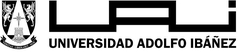

#**Laboratorio 01:** Clasificación lineal multiclase y redes neuronales convolucionales

**Fecha de Entrega:** 23 de abril de 2021

# Integrante(s): 
(*3 alumnos como máximo*)


1.   Alumno 01
2.   Alumno 02 (Opcional)
3.   Alumno 03 (Opcional)


# 1. Introducción

##1.1 Descripción del problema

Dada la base de datos vista en clases de imágenes de perros y gatos, se desea comparar el rendimiento de un clasificador lineal multiclase con respecto a un clasificador basado en redes neuronales profunda del tipo convolucional multiclase. 

Para realizar este trabajo, debe implementar ambos clasificadores utilizando el código visto en clases.

El documento de laboratorio debe contener las siguientes secciones para explicar cada uno de los experimentos:

*  **Librerías**: Debe indicar todas las librerías que serán utilizadas en el laboratorio. Prestando atención en **no colocar librerías** que no serán utilizadas en los experimentos.
*  **Carga de la base de datos**: Incluye el código necesario para poder cargar los datos y la construcción de los _dataloader_.
*  **Diseño del modelo**: Describir brevemente (en formato texto) la arquitectura de la red neuronal a implementar. Indicar la cantidad de datos de entrada, capas ocultas, salidas, número de neuronas, etc.
* **Parámetros y configuración del modelo**: Esta sección debe contener una breve explicación de los parámetros utilizados para la construcción del modelo y una implementación en pytorch.
* **Entrenamiento y validación**: Se deben describir metodológicamente como se realizará el entrenamiento. Definir hiperparámetros, función de coste, etc. Además, debe implementar el código adecuado para la optimización de parámetros utilizando descenso de gradiente (estocástico u otro). 
* **Pruebas**: Implementar el código que permita probar los parámetros, hiperparámetros y modelo, obtenido en la etapa de aprendizaje (entrenamiento). 
* **Resultados**: Calcular las métricas de rendimiento del clasificador para la etapa de entrenamiento y para pruebas. Explique los resultados obtenidos. Utilice la matriz de confusión, presición, recall y tasa de acierto para explicar el comportamiento del modelo.
* **Conclusiones**: La conclusión consiste en sintetizar brevemente los puntos más relevantes, aportando nuevos **conocimientos** explorados en el laboratorio. Las conclusiones no son un resumen de lo realizado sino a lo que ha llevado el desarrollo del proyecto, no perdiendo de vista los objetivos planteados desde el principio y los resultados obtenidos. Es usual concluir con lo que queda por hacer, o sugerencias para mejorar.


##1.2   Objetivos

### Objetivo general
Comparar el rendimiento de dos clasificadores que sean capaces de predecir la existencia de un perro o un gato en una imagen.

### Objetivos específicos
1. Cargar las imágenes e etiquetas de una base de datos basada en directorios y subdirectorios.
2. Entrenar un modelo lineal multiclase para detectar imágenes de perros y gatos.
3. Entrenar un modelo basado en redes neuronales convolucionales para detectar imágenes de perros y gatos.
4. Probar ambos modelos y obtener las métricas de rendimiento: Tasa de acierto (accuracy), precisión (), (recall). 
5. Comparar ambos modelos e indicar cual de los dos tiene el mejor comportamiento y porqué.

##1.3 Librerías 

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
import numpy as np
import PIL

## 1.4 Carga de base de datos desde google drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


Como se van a comparar dos modelos de clasificción, no se harán transformaciones en las imágenes. Tampoco se mezclará el conjunto de entrenamiento. Esto tienee como objetivo comparar ambos entrenamientos y modelos en las mismas condiciones. La idea detrás del laboratorio es encontrar los mejores parámetros e hiperparámtros para ambos modelos con los mismos datos para luego poder compararlos.


In [ ]:
# Transformaciones sobre las imágenes
#data_transform = transforms.Compose([
#        transforms.Resize((128,128)),
#        transforms.RandomAffine(degrees=5, translate=(0.1, 0.1),
#                                scale=None, shear=None, fill=0),
#        torchvision.transforms.Pad(padding=20, fill=0, padding_mode='reflect'),
#        transforms.RandomHorizontalFlip(),
#        transforms.ToTensor()
#    ])

batch_size = 32

data_transform = transforms.Compose(
        [transforms.Resize((28, 28)),
         transforms.Grayscale(num_output_channels=1), 
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.5], std=[0.5])])

# Carga de las imágenes
gatos_perros_train = datasets.ImageFolder(root='/gdrive/My Drive/D-UCN/Classes/TecnicasAvanzadasAprendizajeAutomatico/Laboratorios/Laboratorio05.2:DeepLearning/dataset/training_set',
                                           transform=data_transform)
gatos_perros_valid = datasets.ImageFolder(root='/gdrive/My Drive/D-UCN/Classes/TecnicasAvanzadasAprendizajeAutomatico/Laboratorios/Laboratorio05.2:DeepLearning/dataset/valid_set',
                                           transform=data_transform)
gatos_perros_test = datasets.ImageFolder(root='/gdrive/My Drive/D-UCN/Classes/TecnicasAvanzadasAprendizajeAutomatico/Laboratorios/Laboratorio05.2:DeepLearning/dataset/test_set',
                                           transform=data_transform)
print('Ver la dimesión de la imagen:')
print(gatos_perros_train[0][0].shape)
print('Etiqueta:')
print(gatos_perros_train[0][1])

# Conjunto de entrenamiento
train_loader = torch.utils.data.DataLoader(gatos_perros_train,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=2)

# Conjunto de validación
valid_loader = torch.utils.data.DataLoader(gatos_perros_valid,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=2)

# Conjunto de pruebas
test_loader = torch.utils.data.DataLoader(gatos_perros_test,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=2)

Ver la dimesión de la imagen:
torch.Size([1, 28, 28])
Etiqueta:
0


## 1.5 Visualizar las imágenes de la base de datos

En ciencia de datos siempre es bueno revisar como se está cargando la base de datos con el fin de comprobar la consistencia de estos.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


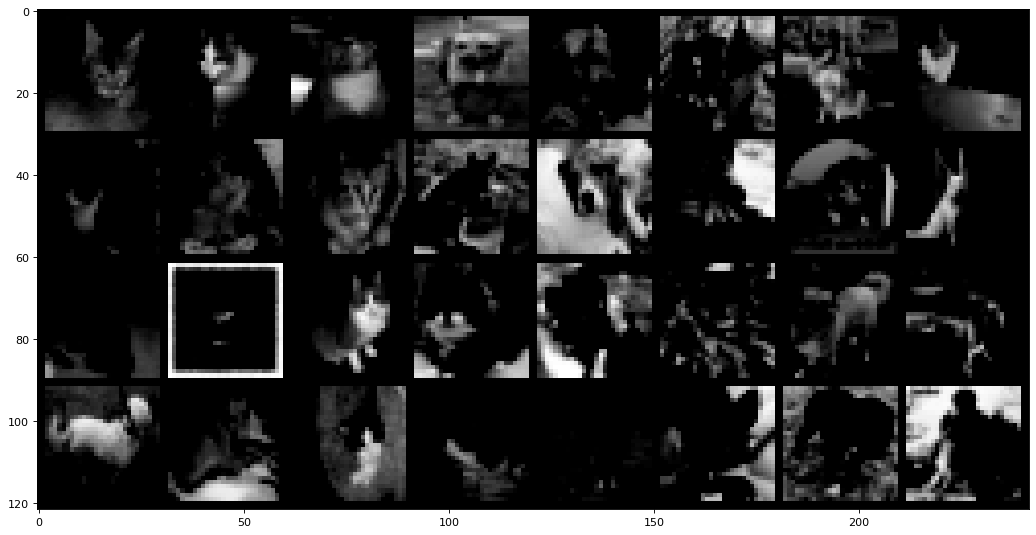

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(num=None, figsize=(16, 14), dpi=80, facecolor='w', edgecolor='k')

def imshow(img):
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img, (1, 2, 0)))

# Obtener imagenes
data_iter = iter(train_loader)
images, labels = data_iter.next()

# Mostrar imagenes
imshow(torchvision.utils.make_grid(images))

#2. Clasificador lineal multiclase

Desarrollo de los experimentos para un clasificador lineal multiclase utilizando la base de datos de imágenes de perros y gatos vista en clases.


## 2.1 Diseño del modelo propuesto

Explicar arquitectura clasificador multiclase:
* Entrada de datos
* Modelo lineal propuesto
* Salida esperada de datos

## 2.2 Parámetros y configuración del modelo

Explicar los parámetros e hiperparámetros seleccionados para la implementación del modelo, función de pérdida y modelo de optimización.

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim

# Implementar modelo (Imágenes de 28x28 y clasificación de dos clases)

linear_model = nn.Linear(784, 2)
#weight, bias = list(linear_model.parameters())
#print(weight.shape)
#print(bias.shape)

# Configurar hiperparámetros
learning_rate = 0.01
weight_decay = 0
num_epochs = 10

# Configurar función de pérdida
criterion = nn.CrossEntropyLoss()

# Configurar modelo de optimización
optimizer = optim.SGD(linear_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

## 3.3 Entrenamiento

Implementar entrenamiento.

In [67]:
def get_accuracy(model, data):
  loader = torch.utils.data.DataLoader(data, batch_size=500)
  correct, total = 0, 0
  for xs, ts in loader:
    xs = xs.view(-1, 784) # Convertir la imagen en un vector
    zs = model(xs)
    pred = zs.max(1, keepdim=True)[1] # Obtener el índice de la clasificiación (logit)
    correct += pred.eq(ts.view_as(pred)).sum().item()
    total += int(ts.shape[0])
  return correct / total

In [68]:
losses = []
iters_sub, train_acc, val_acc = [], [] ,[]

for epoch in range(num_epochs):
  losses_it = []
  for xs, ts in iter(train_loader):
    if len(ts) != batch_size:
      continue
    xs = xs.view(-1, 784) # Convertir la imagen en un vector
    zs = linear_model(xs) # Calcular la prediccion
    loss = criterion(zs, ts) # Calcular el loss total
    loss.backward() # Calcular gradientes
    optimizer.step() # Actualizar parámetros
    optimizer.zero_grad() # Borrar todos los cálculos anteriores en Pytorch
    losses_it.append(float(loss)/batch_size)

  # Guardar la información de entrenamiento de cada ciclo
  print(f'Epoch: {epoch}... ', end='')
  losses.append(sum(losses_it)/len(losses_it)) # Calcular el loss promedio
  iters_sub.append(epoch + 1)
  train_acc.append(get_accuracy(linear_model, gatos_perros_train))
  val_acc.append(get_accuracy(linear_model, gatos_perros_valid))


Epoch: 0... Epoch: 1... Epoch: 2... Epoch: 3... Epoch: 4... Epoch: 5... Epoch: 6... Epoch: 7... Epoch: 8... Epoch: 9... 

### Gráfico de función de pérdida del conjunto de entrenamiento y validación

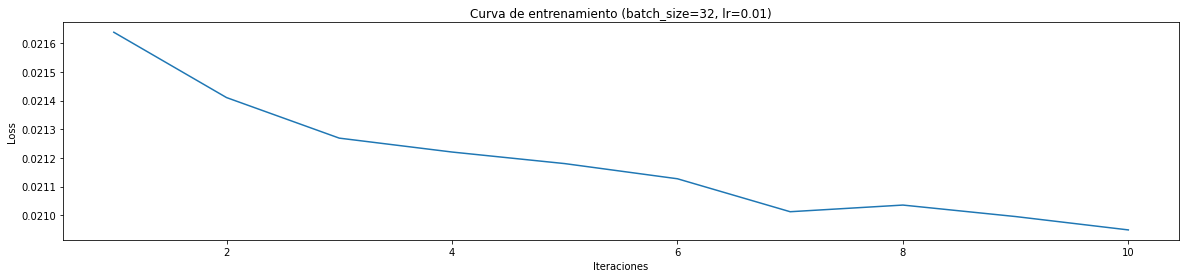

In [69]:
# plotting
plt.figure(figsize=(20, 4))
plt.title("Curva de entrenamiento (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iters_sub, losses, label="Entrenamiento")
plt.xlabel("Iteraciones")
plt.ylabel("Loss")
plt.show()

### Gráfico de tasa de acierto del conjunto de entrenamiento y validación

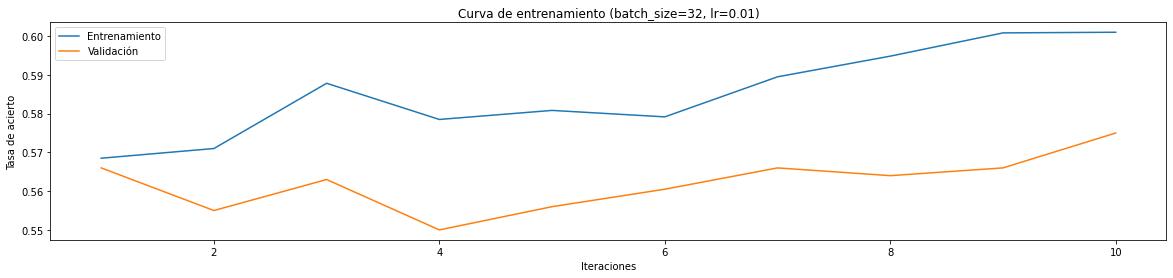

In [70]:
plt.figure(figsize=(20, 4))
plt.title("Curva de entrenamiento (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iters_sub, train_acc, label="Entrenamiento")
plt.plot(iters_sub, val_acc, label="Validación")
plt.xlabel("Iteraciones")
plt.ylabel("Tasa de acierto")
plt.legend(loc='best')
plt.show()

### Visualizar la matriz de pesos resultante
Mostrar una imagen con las matrices resultantes para el problema multiclase.

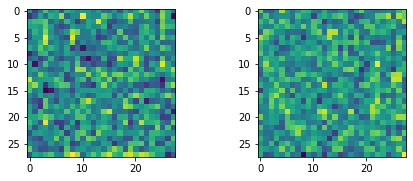

In [71]:
#print(list(model.parameters()))

#for name, param in model.named_parameters():
#    print(name)
#    print(param)
#    print('-'*20)

# Obtengo los parámetros en formato diccionario
d = dict(linear_model.named_parameters())
# Selecciono solo los parámetros que ajunta la regresión lineal
w = d['weight']

import matplotlib.pyplot as plt


f = plt.figure(figsize=(20,6))
# Por cada vector de parámetros pesos grafico (10x728)
for index, template in enumerate(w):
  template = template.detach().numpy().reshape(28,28)
  plt.subplot(2, 5, index+1)
  plt.imshow(template)

## 2.3 Pruebas

Explicar como se realizarán los experimentos y su pruebas. 

Los experimentos del conjunto de pruebas dependen de los hiperparámetros obtenidos en el entrenamiento. Explicar como son fijados esos hiperparámetros para el conjunto de prueba.

## 2.4 Resultados

Mostrar los resultados del **entrenamiento** y **pruebas**. 
Utilizar métricas para mostrar bondad del modelo.(Matríz de confusión)
Utilizar gráficos. Explicar los resultados obtenidos.

### Matriz de confusión

Debe construir una para entrenamiento y otra para pruebas

|            	| Perro Pred. 	| Gato Pred. 	 |
|------------	|:-------------:|:------------:|
| Perro Real 	|      00     	|     00     	 |
| Gato Real  	|      00     	|     00     	 |

### Métricas

Debe construir una para entrenamiento y otra para pruebas

|           	| Clase Perro 	| Clase Gato 	 |
|-----------	|:-------------:|:------------:|
| Precisión 	|    00.00%  	  |    00.00%  	 |
| Recall    	|    00.00%    	|    00.00%  	 |

| Tasa de Acierto Global 	| 00.00% 	|
|------------------------	|:------:	|

#3. Clasificador red neuronal profunda convolucional

Desarrollo de los experimentos para un clasificador basado en redes neuronales profundas. Se utiliza una arquitectura de redes neuronales convolucionales.


## 3.1 Diseño del modelo propuesto

Explicar arquitectura neuronal:
* Entrada de datos
* Modelo de red neural propuesto
* Salida esperada de datos

## 3.2 Parámetros y configuración del modelo

Explicar los parámetros e hiperparámetros seleccionados para la implementación del modelo, función de pérdida y modelo de optimización.

In [ ]:
# Implementar modelo

# Configurar hiperparámetros

# Configurar función de pérdida

# Configurar modelo de optimización

## 3.3 Entrenamiento

Implementar entrenamiento.


In [ ]:
# Implementar entrenamiento

### Gráfico de función de pérdida del conjunto de entrenamiento y validación

### Gráfico de tasa de acierto del conjunto de entrenamiento y validación

### Visualizar los mapas de activación

Mostrar los mapas de activación para un ejemplo de perro y otro para el ejemplo de gato.

## 3.4 Pruebas

Explicar como se realizarán los experimentos y su pruebas. 

Los experimentos del conjunto de pruebas dependen de los hiperparámetros obtenidos en el entrenamiento. Explicar como son fijados esos hiperparámetros para el conjunto de prueba.

## 3.5 Resultados

Mostrar los resultados del entrenamiento y pruebas. 
Utilizar métricas para mostrar bondad del modelo.(Matríz de confusión)
Utilizar gráficos. Explicar los resultados obtenidos.

Debe construir una para entrenamiento y otra para pruebas

|            	| Perro Pred. 	| Gato Pred. 	 |
|------------	|:-------------:|:------------:|
| Perro Real 	|      00     	|     00     	 |
| Gato Real  	|      00     	|     00     	 |

### Métricas

Debe construir una para entrenamiento y otra para pruebas

|           	| Clase Perro 	| Clase Gato 	 |
|-----------	|:-------------:|:------------:|
| Precisión 	|    00.00%  	  |    00.00%  	 |
| Recall    	|    00.00%    	|    00.00%  	 |

| Tasa de Acierto Global 	| 00.00% 	|
|------------------------	|:------:	|




#4. Conclusiones

Conclusiones sobre el uso de la técnica. Ventajas y desventajas. ¿Se cumplen los objetivos del laboratorio?. ¿Como se comparan los resultados con los experimientos hechos en clases para el mismo problema?

